In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import nengo
import nengo_loihi

nengo_loihi.set_defaults()

In [28]:
tau = 0.1


def recurrent_func(x):
    x0, x1 = x
    r = np.sqrt(x0 ** 2 + x1 ** 2)
    a = np.arctan2(x1, x0)
    dr = -(r - 1)
    da = 3.0
    r = r + tau * dr
    a = a + tau * da
    return [r * np.cos(a), r * np.sin(a)]


with nengo.Network(label="Oscillator") as model:
    ens = nengo.Ensemble(1000, dimensions=2)
    nengo.Connection(ens, ens, function=recurrent_func, synapse=tau)
    ens_probe = nengo.Probe(ens, synapse=0.1)

In [33]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(10)
t = sim.trange()

INFO:DRV:  Connecting to 127.0.0.1:42321
INFO:DRV:      Host server up..............Done 0.79s
INFO:DRV:      Encoding axons/synapses.....Done 0.07s
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:DRV:      Compiling MPDS Registers....Done 0.36ms
INFO:HST:  Using Kapoho Bay serial number 446
INFO:DRV:  Connecting to 127.0.0.1:37781
INFO:DRV:      Host server up..............Done 1.21s
INFO:DRV:      Encoding axons/synapses.....Done 0.07s
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:DRV:      Compiling MPDS Registers....Done 0.34ms
INFO:DRV:      Booting up..................Done 2.01s
INFO:DRV:      Encoding probes.............Done 0.35ms
INFO:DRV:      Transferring probes.........Done 1.58ms
INFO:DRV:      Configuring registers.......Done 0.13s
INFO:DRV:      Transferring spikes.........Done 1.28ms
INFO:DRV:      Executing...................Done 30.01s
INFO:DRV:      Processing timeseries.......Done 0.14s
INFO:DRV:  Executor: 10000 timesteps.......Done 30.29s
I

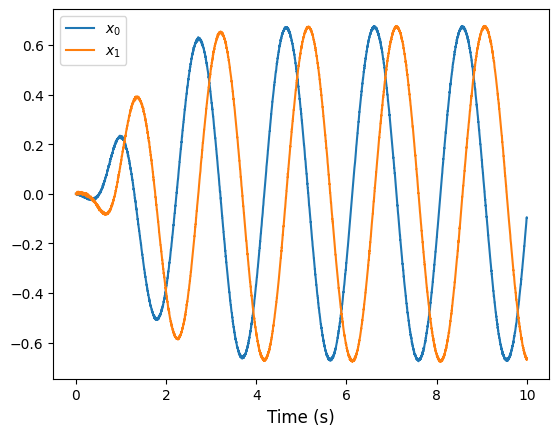

In [31]:
def plot_over_time(t, data):
    plt.figure()
    plt.plot(t, data[ens_probe])
    plt.xlabel("Time (s)", fontsize="large")
    plt.legend(["$x_0$", "$x_1$"])


plot_over_time(t, sim.data)

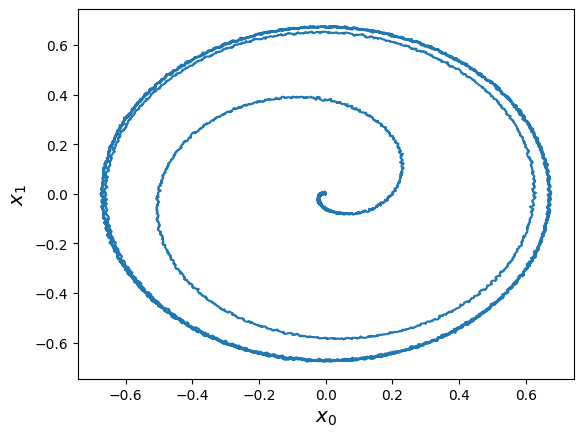

In [32]:
def plot_xy(data):
    plt.figure()
    plt.plot(data[ens_probe][:, 0], data[ens_probe][:, 1])
    plt.xlabel("$x_0$", fontsize="x-large")
    plt.ylabel("$x_1$", fontsize="x-large")


plot_xy(sim.data)